In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'Data')
data_dir

'/Users/dtjgp/Learning/GreenAI/Cloud/4090/Data'

In [3]:
# read the model info, including the model name, the number of parameters, and the number of MACs
# read the model training info, including the training time, each layer's training time, the epoch time and the epoch energy data
data_model_dir = os.path.join(data_dir, 'model_info')
# read all the json fiiels in the data_model_dir
fashionmnist_modelinfodict = json.load(open(os.path.join(data_model_dir, 'fashionmnist_modelinfodict.json')))
cifar100_modelinfodict = json.load(open(os.path.join(data_model_dir, 'cifar100_modelinfodict.json')))
model_datapath_c = json.load(open(os.path.join(data_model_dir, 'model_data_c.json')))
model_datapath_f = json.load(open(os.path.join(data_model_dir, 'model_data_f.json')))
print('the model info of fashionmnist is:', fashionmnist_modelinfodict,'\n', 'the model info of cifar100 is:', cifar100_modelinfodict)
print('the model training info of fashionmnist is in the path:', model_datapath_f, '\n', 'the model training info of cifar100 is in the path:', model_datapath_c)

the model info of fashionmnist is: {'Alexnet': [665530000.0, 57030000.0], 'VGG11': [7580000000.0, 128810000.0], 'VGG13': [11300000000.0, 128990000.00000001], 'VGG16': [15460000000.0, 134300000.0], 'ResNet18': [1750000000.0, 11180000.0], 'ResNet34': [3600000000.0, 21290000.0], 'ResNet50': [2320000000.0, 13870000.0], 'GoogleNet': [1520000000.0, 5980000.0], 'GoogleNet_mod0': [406930000.0, 120070.0], 'GoogleNet_mod1': [1090000000.0, 3420000.0], 'GoogleNet_mod2': [1870000000.0, 7280000.0], 'GoogleNet_mod3': [2740000000.0, 11710000.0], 'GoogleNet_mod4': [3710000000.0, 16700000.0], 'GoogleNet_mod5': [455030000.0, 426780.0], 'GoogleNet_mod6': [578900000.0, 1320000.0], 'GoogleNet_mod7': [778240000.0, 2790000.0], 'GoogleNet_mod8': [1050000000.0, 4840000.0], 'GoogleNet_mod9': [544400000.0, 738300.0], 'GoogleNet_mod10': [688040000.0, 1400000.0], 'GoogleNet_mod11': [837560000.0, 2100000.0], 'GoogleNet_mod12': [992940000.0, 2830000.0]} 
 the model info of cifar100 is: {'Alexnet': [712390000.0, 57040

In [4]:
# fashionmnist data，read the model_data_f
ModelData_f = {}
for model_name, model_data_path in model_datapath_f.items():
    # the path is like /root/GreenAI/Cloud/4090/Data/alexnet_AllLayers/fashion_mnist/E20_B256_R0, but need to change to /Users/dtjgp/Learning/GreenAI/Cloud/4090/Data/alexnet_AllLayers/fashion_mnist/E20_B256_R0
    model_data_path = model_data_path.replace('/root/GreenAI/Cloud/4090', '/Users/dtjgp/Learning/GreenAI/Cloud/4090')
    # read the data from the model_data_path, load the npy file
    LayersTime = np.load(os.path.join(model_data_path, 'Layers_time.npy'), allow_pickle=True)
    TrainPartTime = np.load(os.path.join(model_data_path, 'Train_part_time.npy'), allow_pickle=True)
    EpochTime = np.load(os.path.join(model_data_path, 'Epoch_time.npy'), allow_pickle=True)
    EpochEnergy = np.load(os.path.join(model_data_path, 'Epoch_energy.npy'), allow_pickle=True)
    ModelData_f[model_name] = {'LayersTime': LayersTime, 'TrainPartTime': TrainPartTime, 'EpochTime': EpochTime, 'EpochEnergy': EpochEnergy}

# cifar100 data，read the model_data_c
ModelData_c = {}
for model_name, model_data_path in model_datapath_c.items():
    model_data_path = model_data_path.replace('/root/GreenAI/Cloud/4090', '/Users/dtjgp/Learning/GreenAI/Cloud/4090')
    LayersTime = np.load(os.path.join(model_data_path, 'Layers_time.npy'), allow_pickle=True)  
    TrainPartTime = np.load(os.path.join(model_data_path, 'Train_part_time.npy'), allow_pickle=True)
    EpochTime = np.load(os.path.join(model_data_path, 'Epoch_time.npy'), allow_pickle=True)
    EpochEnergy = np.load(os.path.join(model_data_path, 'Epoch_energy.npy'), allow_pickle=True)
    ModelData_c[model_name] = {'LayersTime': LayersTime, 'TrainPartTime': TrainPartTime, 'EpochTime': EpochTime, 'EpochEnergy': EpochEnergy}
    
# print the data
# print('the model data of fashionmnist is:', ModelData_f, '\n', 'the model data of cifar100 is:', ModelData_c)

In [5]:
def GetModeldf(modelinfodict):
    model_df = pd.DataFrame(modelinfodict).T.reset_index()
    model_df.columns = ['Model', 'MACs','Parameters']
    return model_df

def GetEpochEnergydf(ModelData):
    model_epochenergy = {}
    for model_name, model_data in ModelData.items():
        model_epochenergy_data = model_data['EpochEnergy']
        model_energy_postprocessdata = np.zeros((model_epochenergy_data.shape[0], 2))
        # get the total energy and average energy of each epoch and save them in the model_energy_postprocessdata
        for i in range(model_epochenergy_data.shape[0]):
            epoch_energy_data = model_epochenergy_data[i][0]
            record_epoch_lenth = len(epoch_energy_data)
            total_epoch_energy = sum(epoch_energy_data)
            avg_epoch_energy = total_epoch_energy / record_epoch_lenth
            model_energy_postprocessdata[i, 0] = total_epoch_energy
            model_energy_postprocessdata[i, 1] = avg_epoch_energy
            # print('the total energy of epoch', i, 'is:', total_epoch_energy, 'the average energy of epoch', i, 'is:', avg_epoch_energy,'the record epoch lenth is:', record_epoch_lenth)
        modelenergy_totalperepoch = np.mean(model_energy_postprocessdata[:, 0])
        modelenergy_avgperepoch = np.mean(model_energy_postprocessdata[:, 1])
        # round the energy to 2 decimal
        modelenergy_totalperepoch = round(modelenergy_totalperepoch, 2)
        modelenergy_avgperepoch = round(modelenergy_avgperepoch, 2)
        model_epochenergy[model_name] = {'TotalEnergyPerEpoch': modelenergy_totalperepoch, 'AverageEnergyPerSec': modelenergy_avgperepoch}
    energy_df = pd.DataFrame(model_epochenergy).T.reset_index()
    energy_df.columns = ['Model', 'TotalEnergyPerEpoch', 'AverageEnergyPerSec']
    return energy_df

def GetEpochTimedf(ModelData):
    # analyze the epoch energy time
    model_epochtime = {}
    for model_name, model_data in ModelData.items():
        model_epochtime_data = model_data['EpochTime']
        model_totaltime = sum(model_epochtime_data)
        model_avgtime = model_totaltime / len(model_epochtime_data)
        model_totaltime = round(model_totaltime, 2)
        model_avgtime = round(model_avgtime, 2)
        model_epochtime[model_name] = {'TotalTime': model_totaltime, 'AverageTimeperEpoch': model_avgtime}
    time_df = pd.DataFrame(model_epochtime).T.reset_index()
    time_df.columns = ['Model', 'TotalTime', 'AverageTimeperEpoch']
    return time_df

def GetTrainPartTimedf(ModelData):
    # analyze the epoch energy time
    model_trainparttime = {}
    for model_name, model_data in ModelData.items():
        model_trainparttime_data = model_data['TrainPartTime']
        data_shape = model_trainparttime_data.shape[0]
        if data_shape == 6:
            # drop the model_trainparttime_data third row and fifth row
            model_trainparttime_data = np.delete(model_trainparttime_data, 2, axis=0)
            model_trainparttime_data = np.delete(model_trainparttime_data, 3, axis=0)
        # print('the shape after drop is:', model_trainparttime_data.shape)
        trainparttime_data = np.zeros((model_trainparttime_data.shape[0], 2))
        trainparttime_total = np.sum(model_trainparttime_data, axis=1)
        trainparttime_avg = np.mean(model_trainparttime_data, axis=1)
        # round the energy to 2 decimal
        trainparttime_total = np.round(trainparttime_total, 2)
        trainparttime_avg = np.round(trainparttime_avg, 2)
        trainparttime_data[:, 0] = trainparttime_total
        trainparttime_data[:, 1] = trainparttime_avg
        model_trainparttime[model_name] = trainparttime_data
    data = []
    for model, times in model_trainparttime.items():
        flattened_times = [item for sublist in times for item in sublist]
        data.append([model] + flattened_times)
    columns = ['Model', 
            'Total Time to Device', 'Average Time to Device', 
            'Total Forward Time', 'Average Forward Time', 
            'Total Backward Time', 'Average Backward Time', 
            'Total Test Time', 'Average Test Time']
    train_part_time_df = pd.DataFrame(data, columns=columns)
    return train_part_time_df

def GetFinaldf(model_df, energy_df, time_df, train_part_time_df):
    df = pd.merge(model_df, energy_df, on='Model')
    df = pd.merge(df, time_df, on='Model')
    df = pd.merge(df, train_part_time_df, on='Model')
    return df
    

In [6]:
def PlotMACs_vs_Energy(df):
    palette = sns.color_palette("husl", len(df))
    
    plt.figure(figsize=(10,6))
    # MACs vs Total Energy per Epoch
    sns.scatterplot(data=df, x='MACs', y='TotalEnergyPerEpoch', hue='Model', palette=palette)
    for i in range(df.shape[0]):    
        plt.text(df['MACs'][i], df['TotalEnergyPerEpoch'][i], df['Model'][i], fontsize=7, color=palette[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('MACs')
    plt.ylabel('Total Energy per Epoch')
    plt.title('MACs vs Total Energy per Epoch')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
    plt.figure(figsize=(10, 6))
    # MACs vs Average Energy per Epoch
    sns.scatterplot(data=df, x='MACs', y='AverageEnergyPerSec', hue='Model', palette=palette)
    for i in range(df.shape[0]):
        plt.text(df['MACs'][i], df['AverageEnergyPerSec'][i], df['Model'][i], fontsize=7, color=palette[i])
    plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('MACs')
    plt.ylabel('Average Energy per Second')
    plt.title('MACs vs Average Energy per Second')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
def PlotParas_vs_Time(df):
    palette = sns.color_palette("husl", len(df))
    
    plt.figure(figsize=(10, 6))
    # Parameters vs Total Energy per Epoch
    sns.scatterplot(data=df, x='Parameters', y='TotalEnergyPerEpoch', hue='Model', palette=palette)
    for i in range(df.shape[0]):
        plt.text(df['Parameters'][i], df['TotalEnergyPerEpoch'][i], df['Model'][i], fontsize=7, color=palette[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Parameters')
    plt.ylabel('Total Energy per Epoch')
    plt.title('Parameters vs Total Energy per Epoch')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
    plt.figure(figsize=(10, 6))
    # Parameters vs Average Energy per Epoch
    sns.scatterplot(data=df, x='Parameters', y='AverageEnergyPerSec', hue='Model', palette=palette)
    for i in range(df.shape[0]):
        plt.text(df['Parameters'][i], df['AverageEnergyPerSec'][i], df['Model'][i], fontsize=7, color=palette[i])
    plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('Parameters')
    plt.ylabel('Average Energy per Second')
    plt.title('Parameters vs Average Energy per Second')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [7]:
def PlotMACs_vs_TrainPartTime(df):
    # Define a color palette for the points
    palette = sns.color_palette("husl", len(df))

    # Plot 1: MACs vs Total Time to Device
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='MACs', y='Total Time to Device', hue='Model', palette=palette)
    for i in range(df.shape[0]):
        plt.text(df['MACs'][i], df['Total Time to Device'][i], df['Model'][i], fontsize=7, color=palette[i])
    plt.xlabel('MACs')
    plt.ylabel('Total Time to Device (seconds)')
    plt.title('MACs vs Total Time to Device')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

    # Plot 2: MACs vs Total Forward Time
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='MACs', y='Total Forward Time', hue='Model', palette=palette)
    for i in range(df.shape[0]):
        plt.text(df['MACs'][i], df['Total Forward Time'][i], df['Model'][i], fontsize=7, color=palette[i])
    plt.xscale('log')
    plt.xlabel('MACs')
    plt.ylabel('Total Forward Time (seconds)')
    plt.title('MACs vs Total Forward Time')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

    # Plot 3: MACs vs Total Backward Time
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='MACs', y='Total Backward Time', hue='Model', palette=palette)
    for i in range(df.shape[0]):
        plt.text(df['MACs'][i], df['Total Backward Time'][i], df['Model'][i], fontsize=7, color=palette[i])
    plt.xscale('log')
    plt.xlabel('MACs')
    plt.ylabel('Total Backward Time (seconds)')
    plt.title('MACs vs Total Backward Time')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

    # Plot 4: MACs vs Total Test Time
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='MACs', y='Total Test Time', hue='Model', palette=palette)   
    for i in range(df.shape[0]):
        plt.text(df['MACs'][i], df['Total Test Time'][i], df['Model'][i], fontsize=7, color=palette[i])
    plt.xscale('log')
    plt.xlabel('MACs')
    plt.ylabel('Total Test Time (seconds)')
    plt.title('MACs vs Total Test Time')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [8]:
def PlotParas_vs_TrainPartTime(df):
    # Define a color palette for the points
    palette = sns.color_palette("husl", len(df))
    
    # Plot 1: MACs vs Total Time to Device
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Parameters', y='Total Time to Device', hue='Model', palette=palette)
    for i in range(df.shape[0]):
        plt.text(df['Parameters'][i], df['Total Time to Device'][i], df['Model'][i], fontsize=7, color=palette[i])
    plt.xlabel('Params')
    plt.ylabel('Total Time to Device (seconds)')
    plt.title('Params vs Total Time to Device')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

    # Plot 2: MACs vs Total Forward Time
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Parameters', y='Total Forward Time', hue='Model', palette=palette)
    for i in range(df.shape[0]):
        plt.text(df['Parameters'][i], df['Total Forward Time'][i], df['Model'][i], fontsize=7, color=palette[i])
    plt.xscale('log')
    plt.xlabel('Params')
    plt.ylabel('Total Forward Time (seconds)')
    plt.title('Params vs Total Forward Time')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

    # Plot 3: MACs vs Total Backward Time
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Parameters', y='Total Backward Time', hue='Model', palette=palette)
    for i in range(df.shape[0]):
        plt.text(df['Parameters'][i], df['Total Backward Time'][i], df['Model'][i], fontsize=7, color=palette[i])
    plt.xscale('log')
    plt.xlabel('Params')
    plt.ylabel('Total Backward Time (seconds)')
    plt.title('Params vs Total Backward Time')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

    # Plot 4: MACs vs Total Test Time
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Parameters', y='Total Test Time', hue='Model', palette=palette)   
    for i in range(df.shape[0]):
        plt.text(df['Parameters'][i], df['Total Test Time'][i], df['Model'][i], fontsize=7, color=palette[i])
    plt.xscale('log')
    plt.xlabel('Params')
    plt.ylabel('Total Test Time (seconds)')
    plt.title('Params vs Total Test Time')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [9]:
def PlotEpochEnergy_vs_EpochTime(df):
    # Define a color palette for the points
    palette = sns.color_palette("husl", len(df))
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='AverageTimeperEpoch', y='TotalEnergyPerEpoch', hue='Model', palette=palette)   
    for i in range(df.shape[0]):
        plt.text(df['AverageTimeperEpoch'][i], df['TotalEnergyPerEpoch'][i], df['Model'][i], fontsize=7, color=palette[i])
    plt.xscale('log')
    plt.xlabel('Avg Time per Epcoh(s)')
    plt.ylabel('Total Energy per Epoch(J)')
    plt.title('Avg Time vs Energy per Epoch')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [10]:
def PlotForwardTime_vs_BackwardTime(df):
    # Define a color palette for the points
    palette = sns.color_palette("husl", len(df))
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Total Forward Time', y='Total Backward Time', hue='Model', palette=palette)   
    for i in range(df.shape[0]):
        plt.text(df['Total Forward Time'][i], df['Total Backward Time'][i], df['Model'][i], fontsize=7, color=palette[i])
    # plt.xscale('log')
    plt.xlabel('Total Forward Time per Epcoh(s)')
    plt.ylabel('Total Backward Time per Epcoh(s)')
    plt.title('Forward Time vs Backward Time per Epoch')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [11]:
model_df_f = GetModeldf(fashionmnist_modelinfodict)
energy_df_f = GetEpochEnergydf(ModelData_f)
time_df_f = GetEpochTimedf(ModelData_f)
train_part_time_df_f = GetTrainPartTimedf(ModelData_f)
df_f = GetFinaldf(model_df_f, energy_df_f, time_df_f, train_part_time_df_f)
# df_f

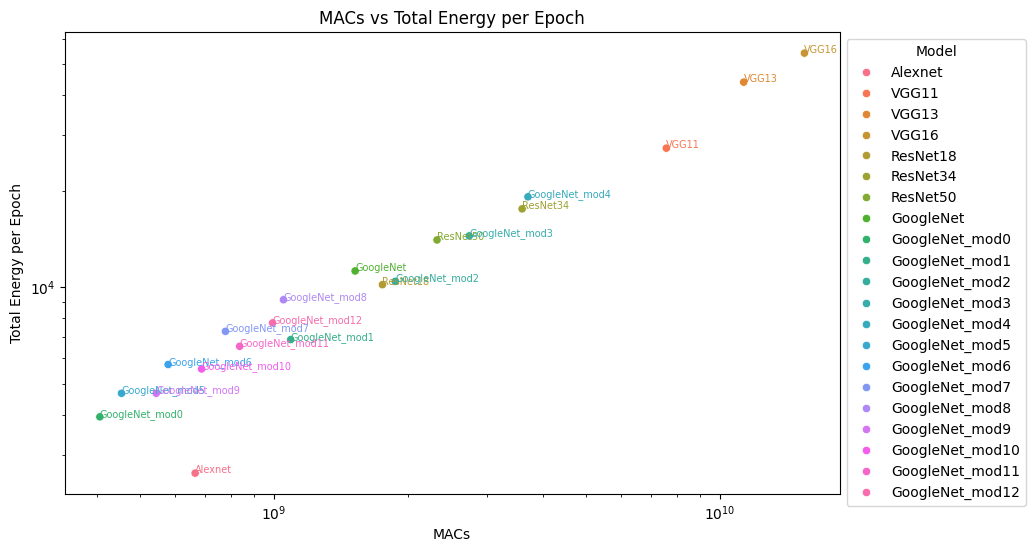

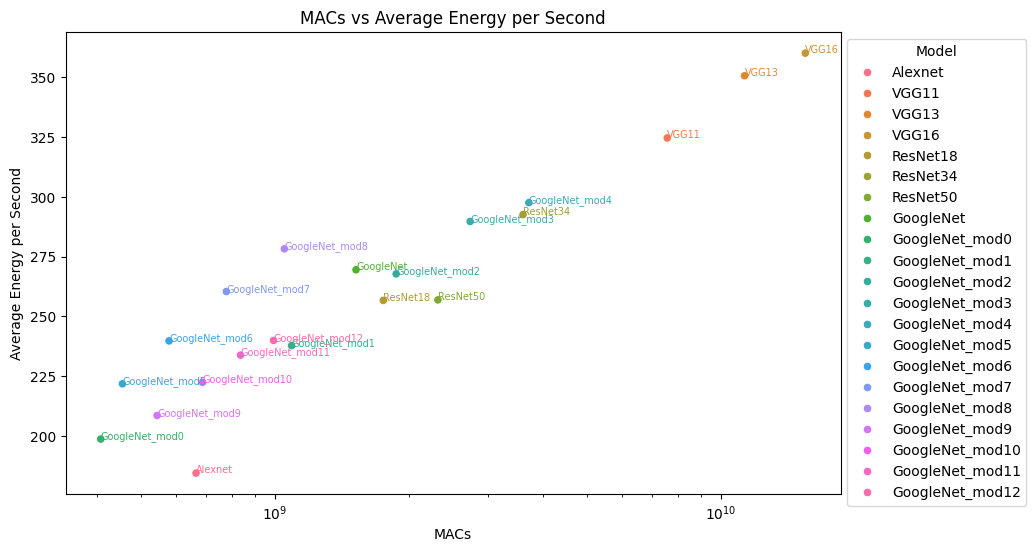

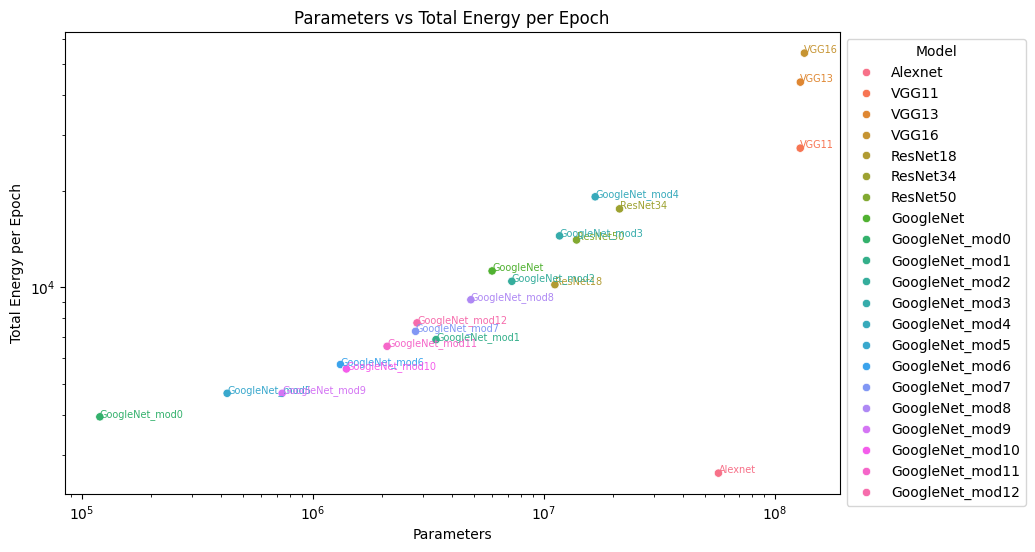

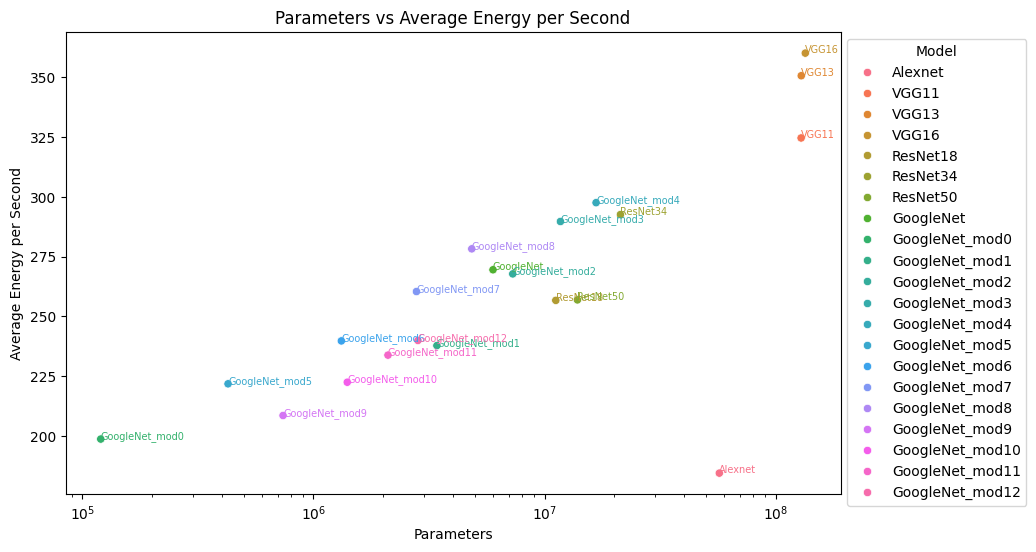

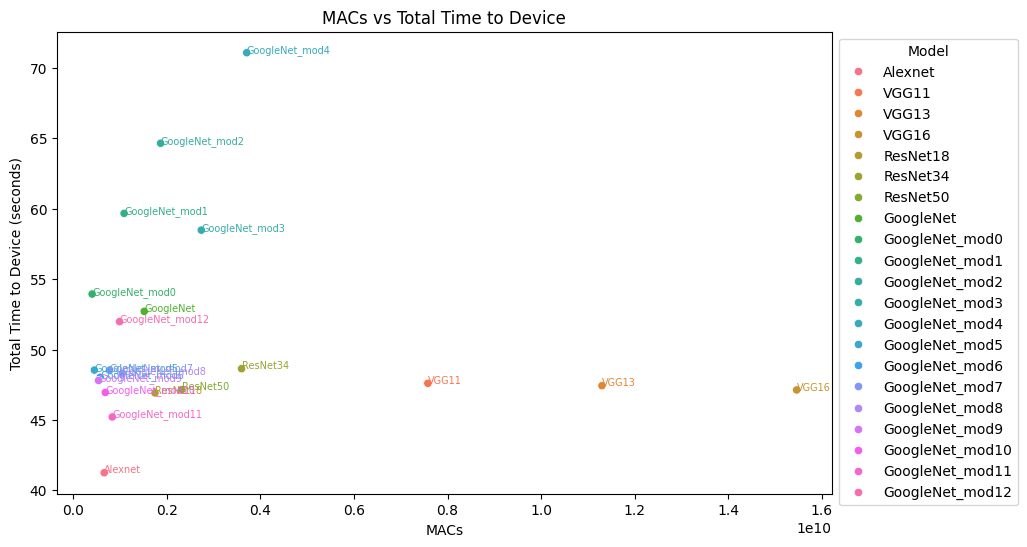

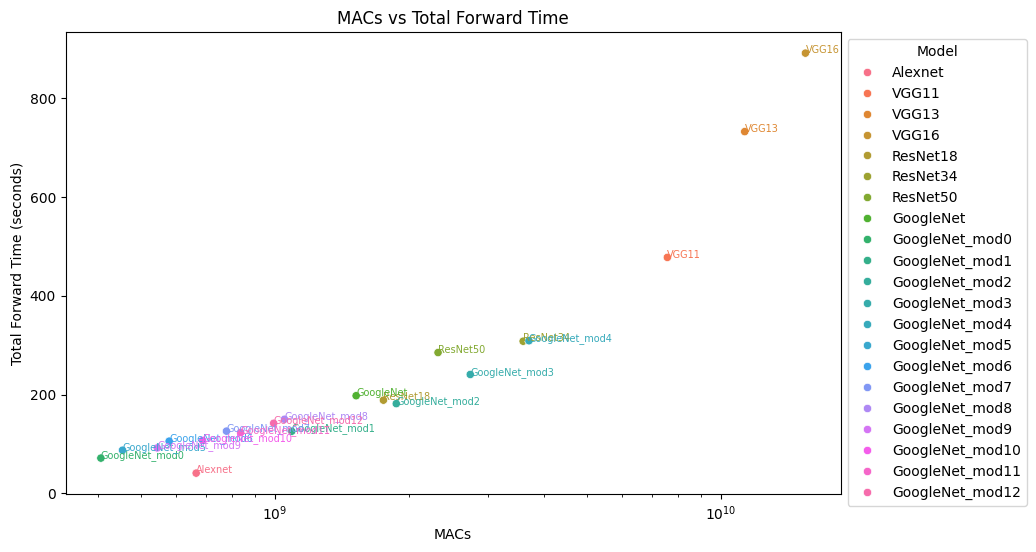

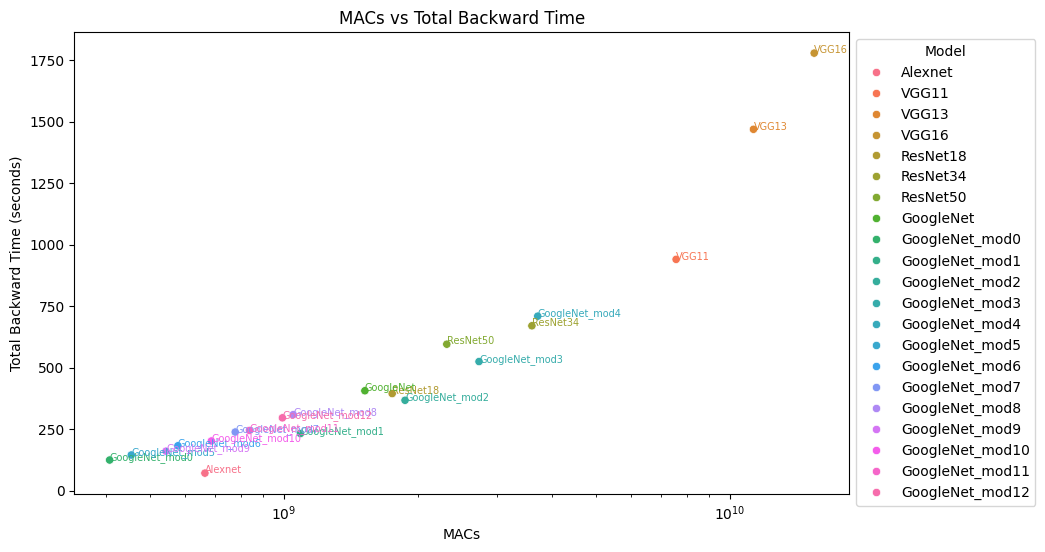

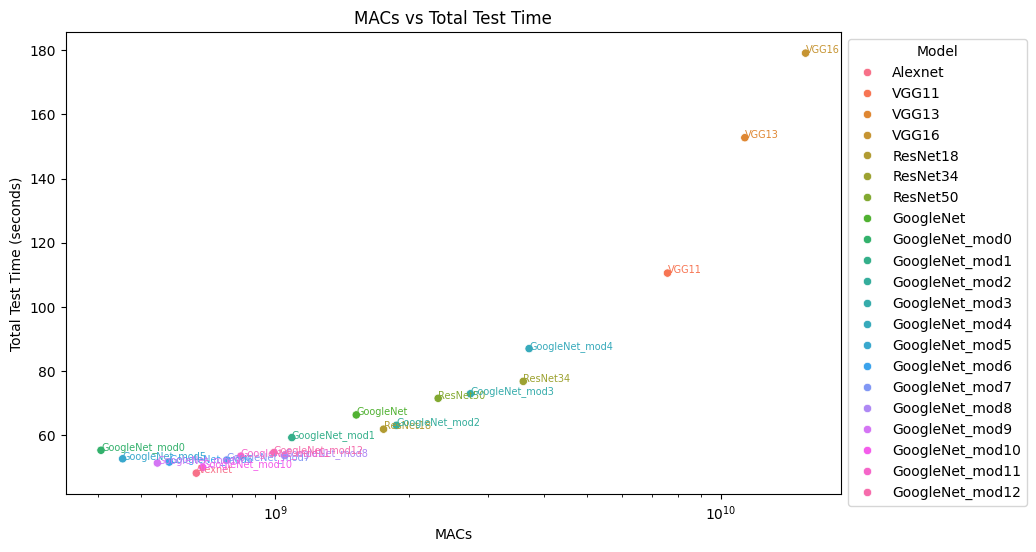

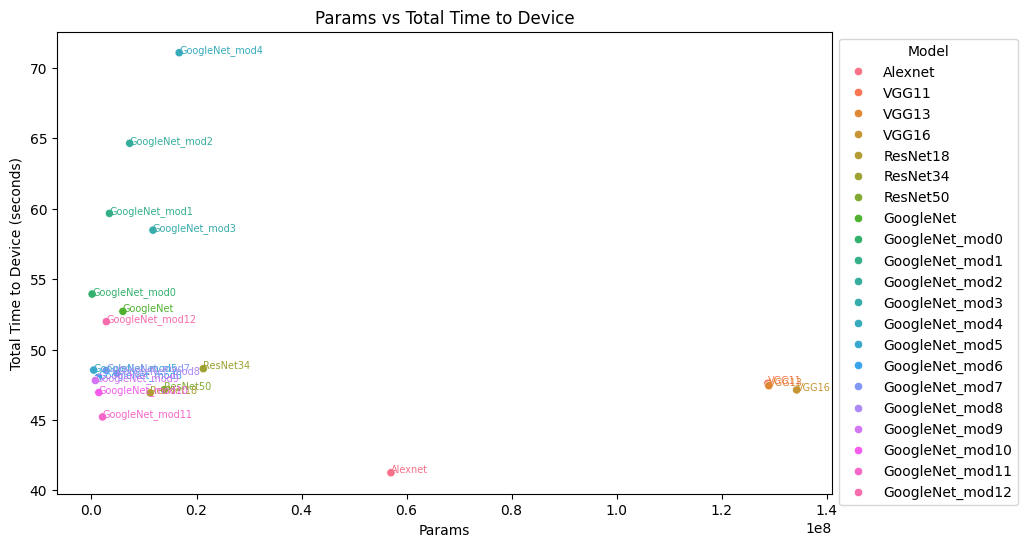

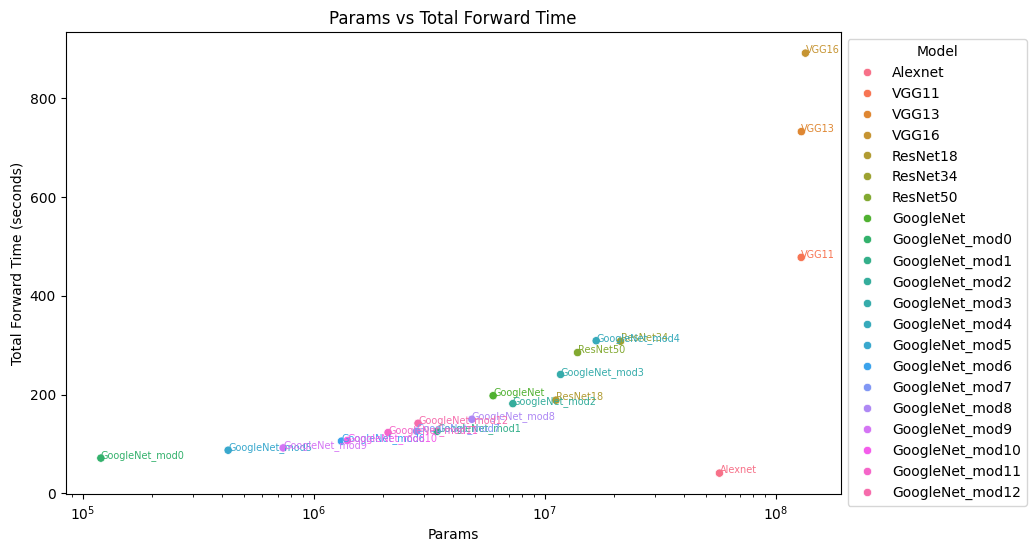

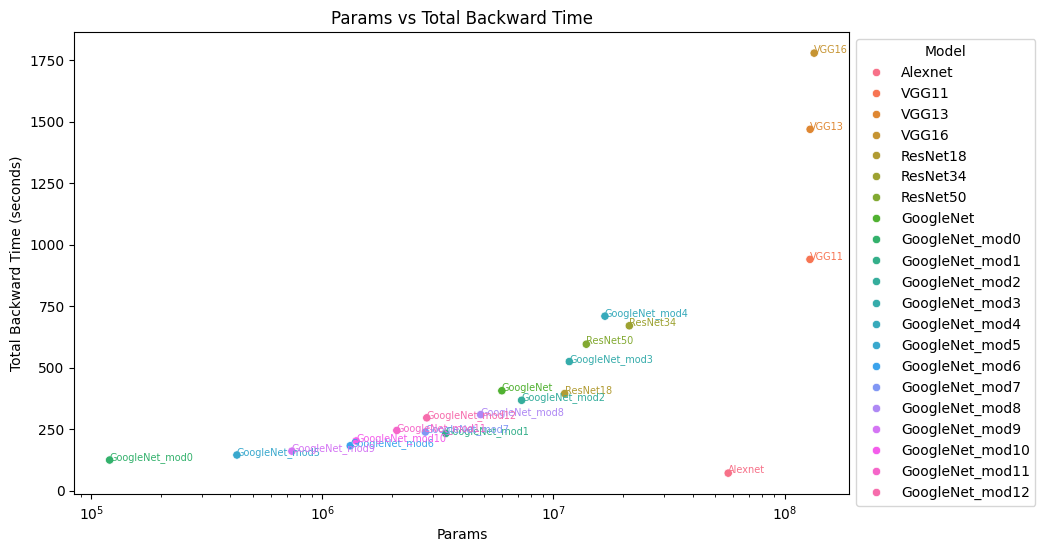

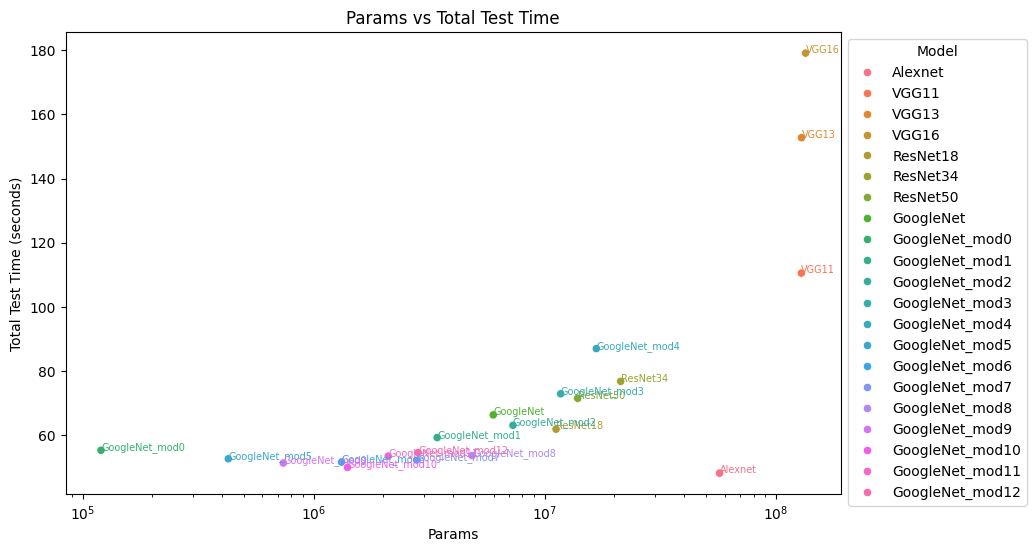

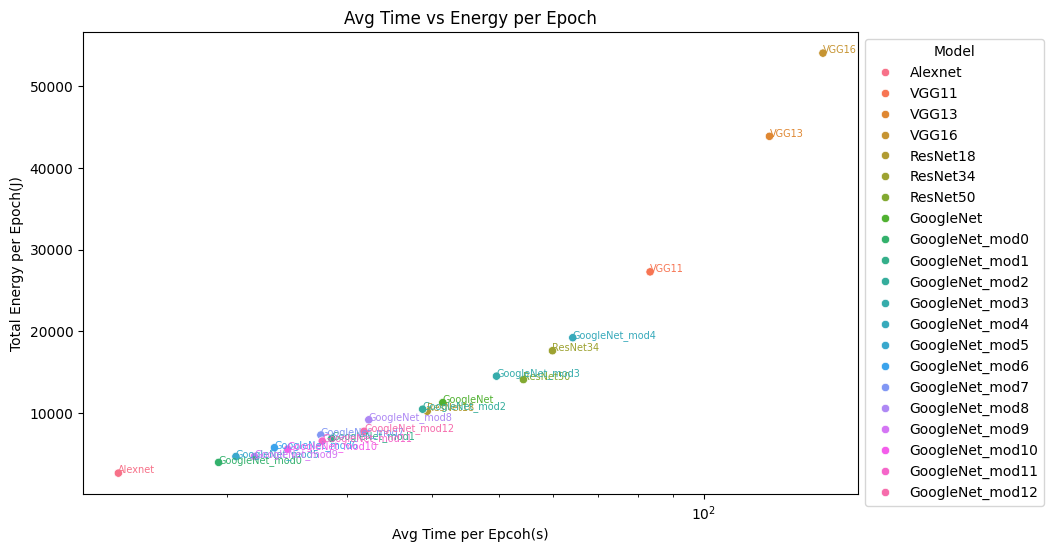

In [12]:
PlotMACs_vs_Energy(df_f)
PlotParas_vs_Time(df_f)
PlotMACs_vs_TrainPartTime(df_f)
PlotParas_vs_TrainPartTime(df_f)
PlotEpochEnergy_vs_EpochTime(df_f)

In [13]:
model_df_c = GetModeldf(cifar100_modelinfodict)
energy_df_c = GetEpochEnergydf(ModelData_c)
time_df_c = GetEpochTimedf(ModelData_c)
train_part_time_df_c = GetTrainPartTimedf(ModelData_c)
df_c = GetFinaldf(model_df_c, energy_df_c, time_df_c, train_part_time_df_c)
# df_f

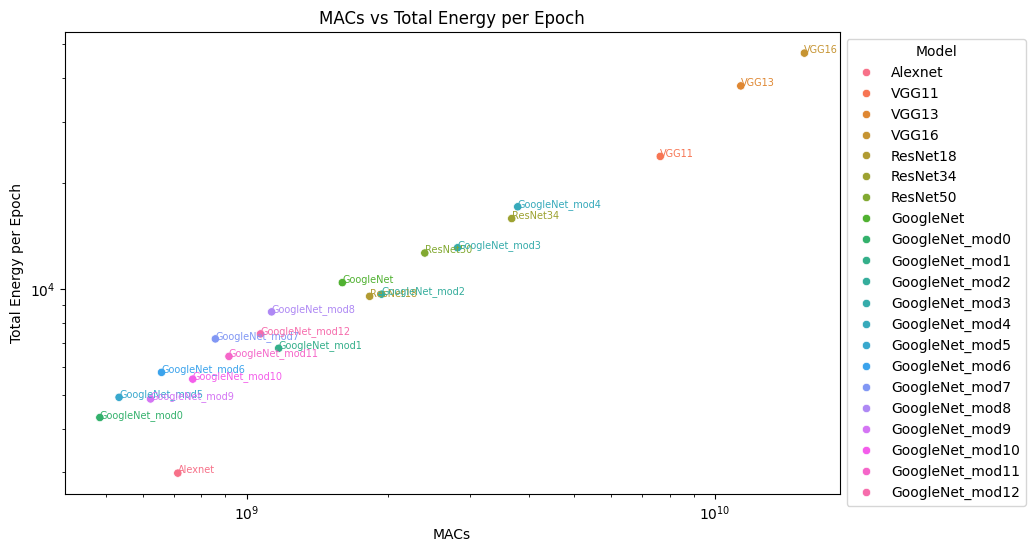

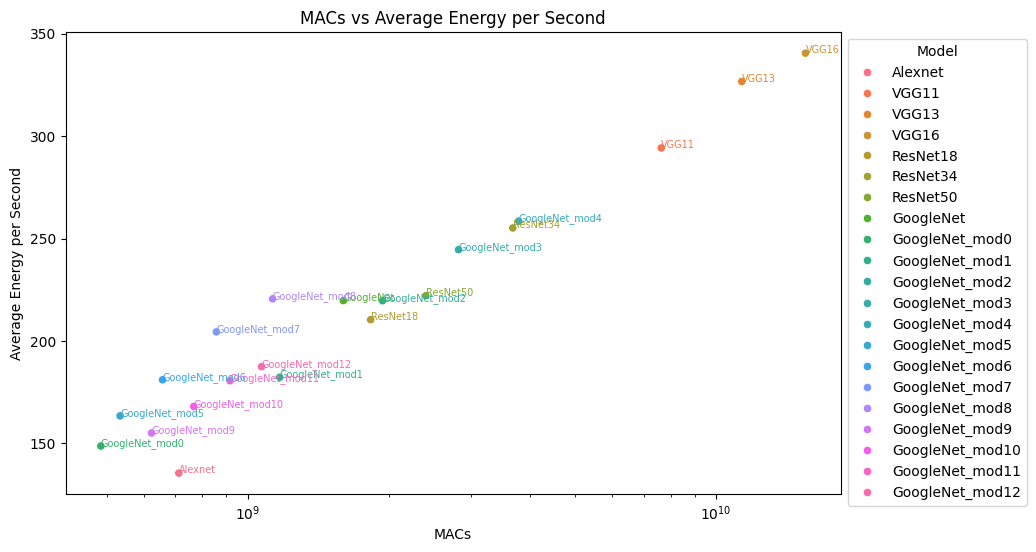

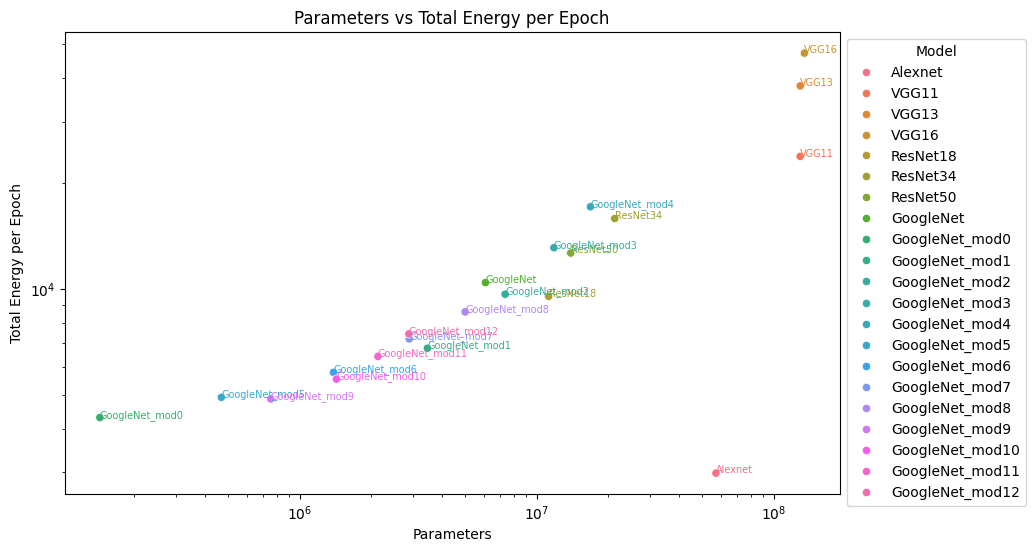

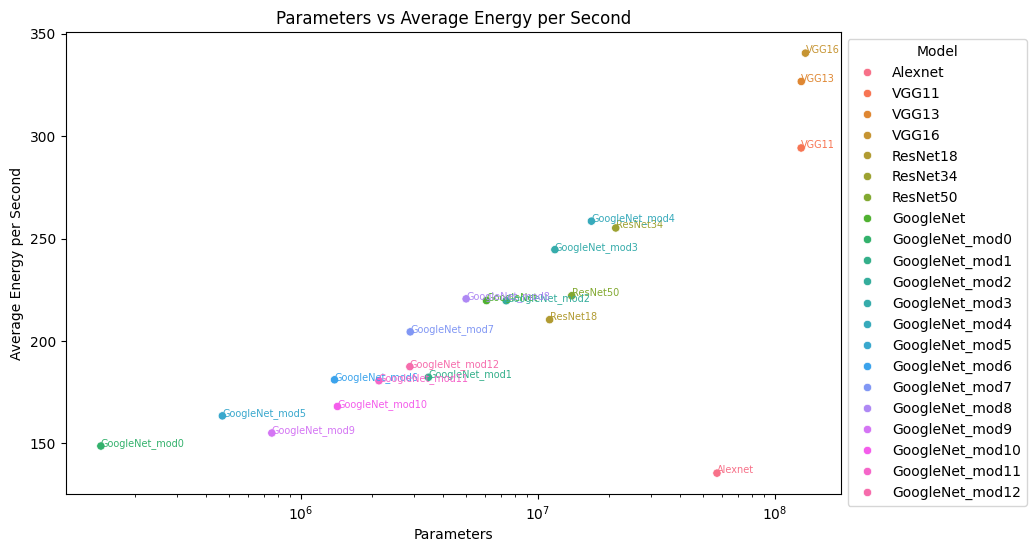

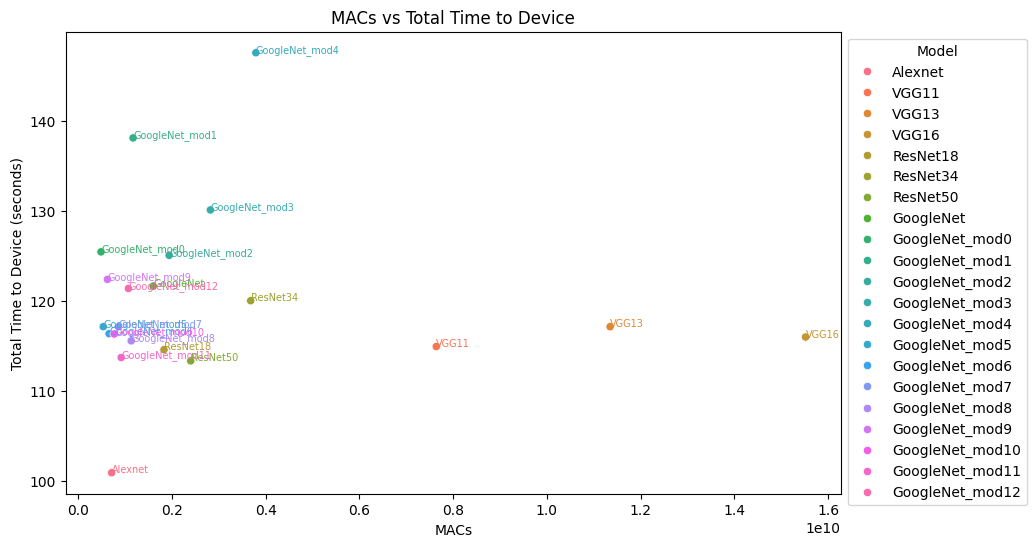

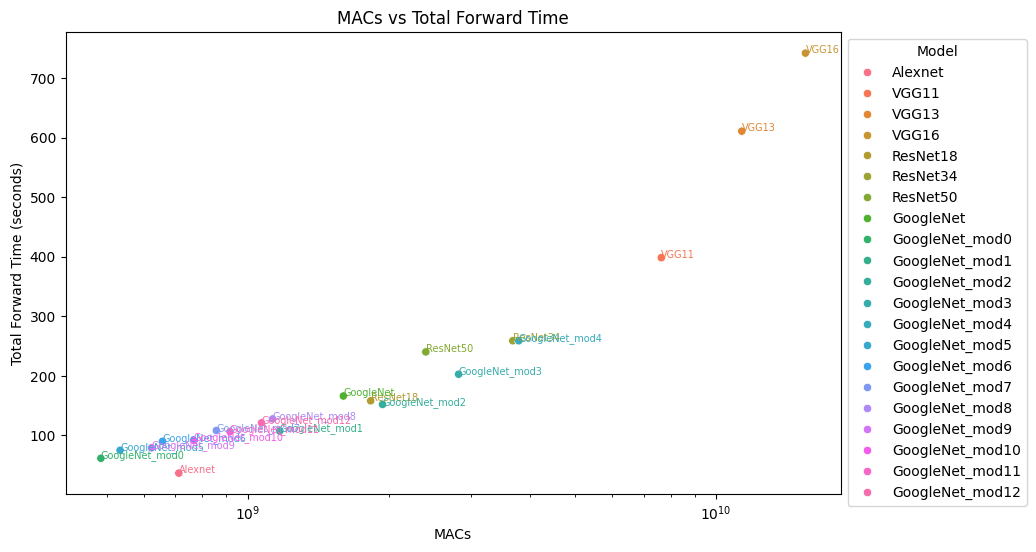

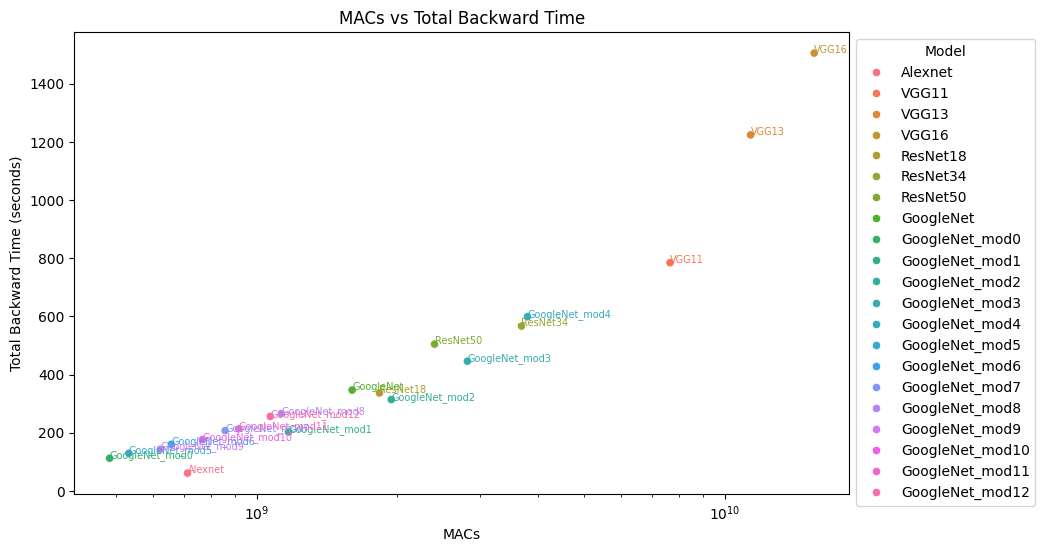

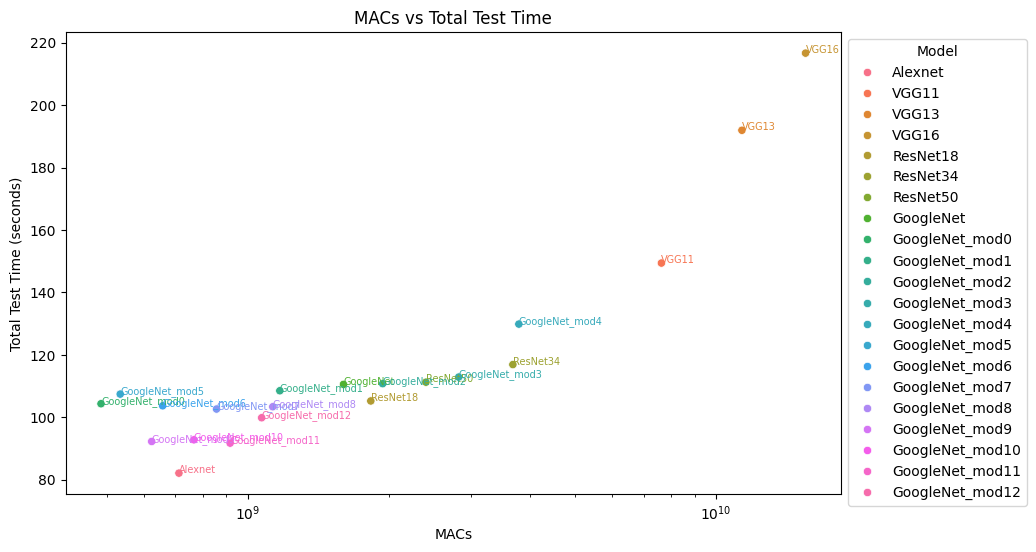

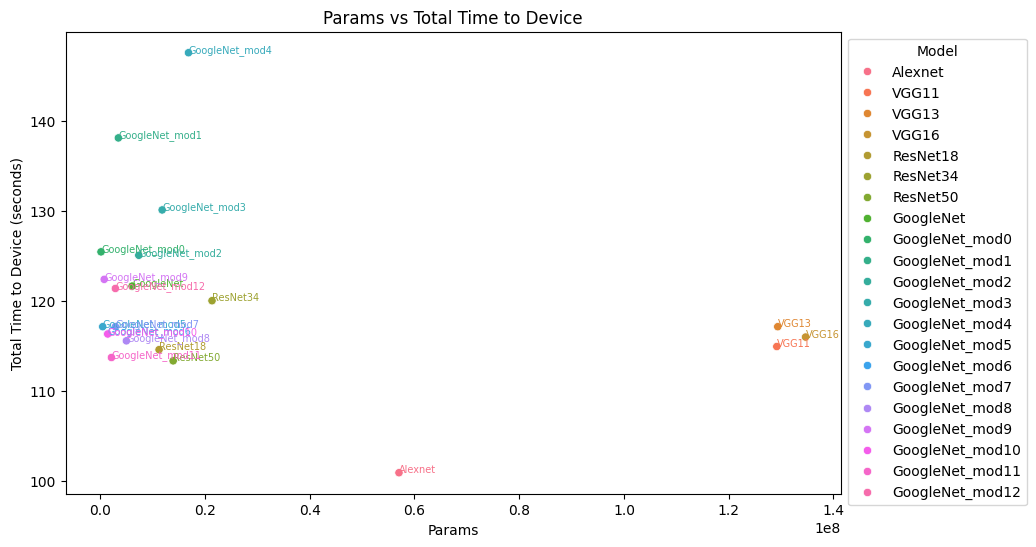

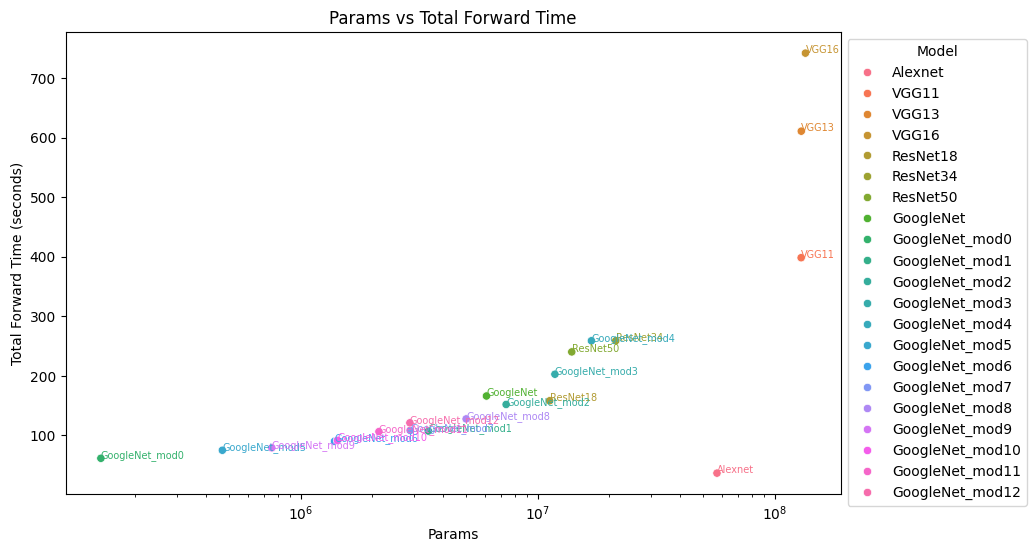

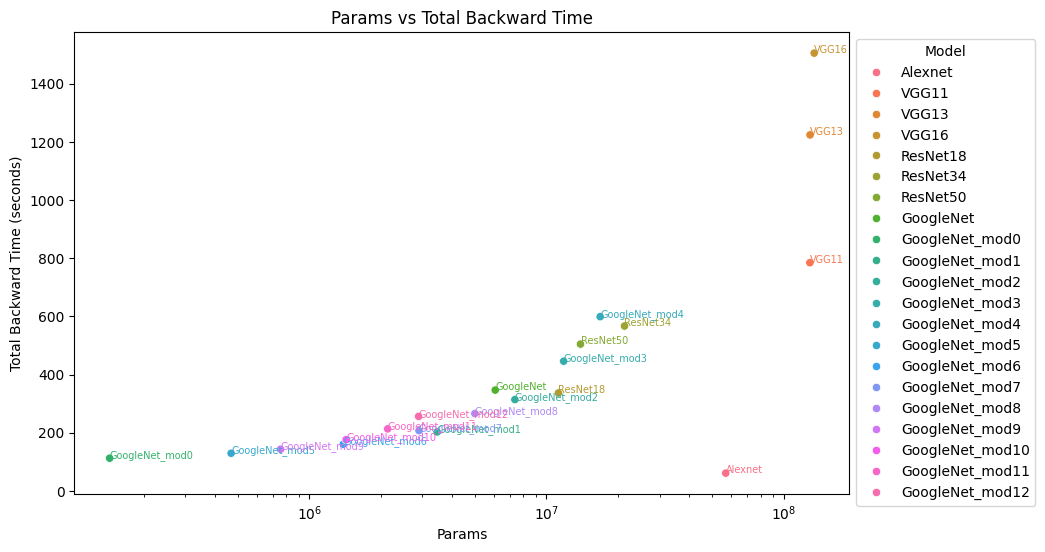

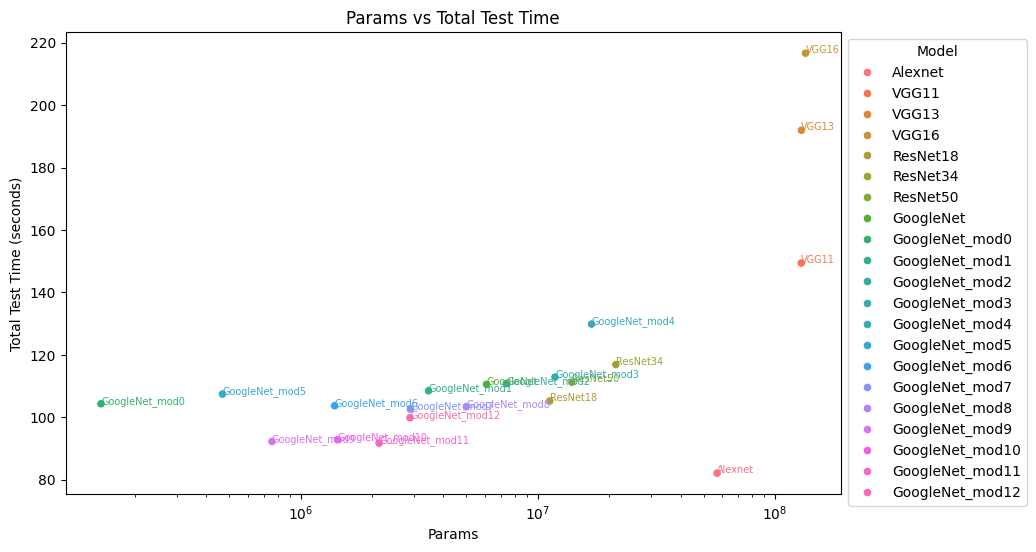

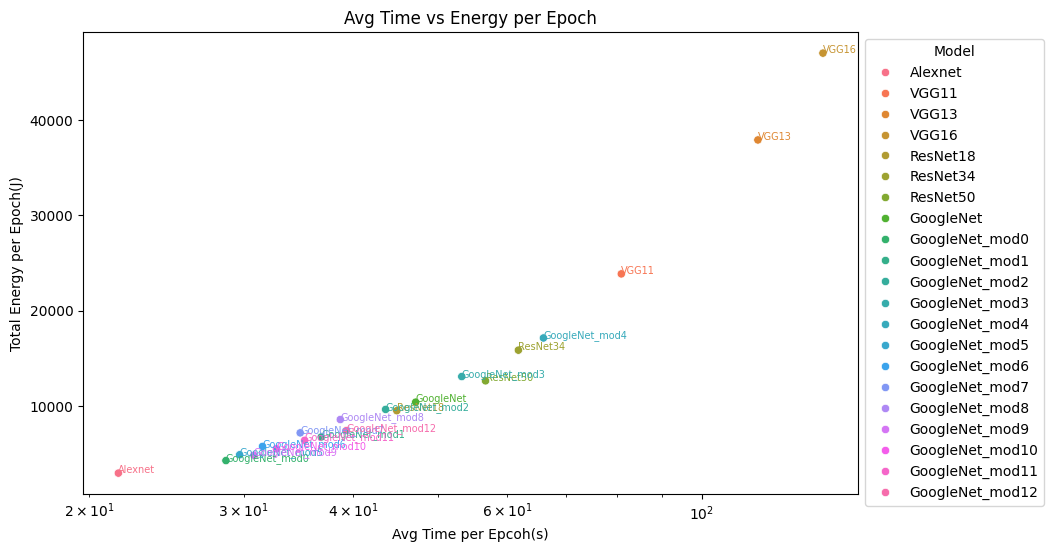

In [14]:
PlotMACs_vs_Energy(df_c)
PlotParas_vs_Time(df_c)
PlotMACs_vs_TrainPartTime(df_c)
PlotParas_vs_TrainPartTime(df_c)
PlotEpochEnergy_vs_EpochTime(df_c)

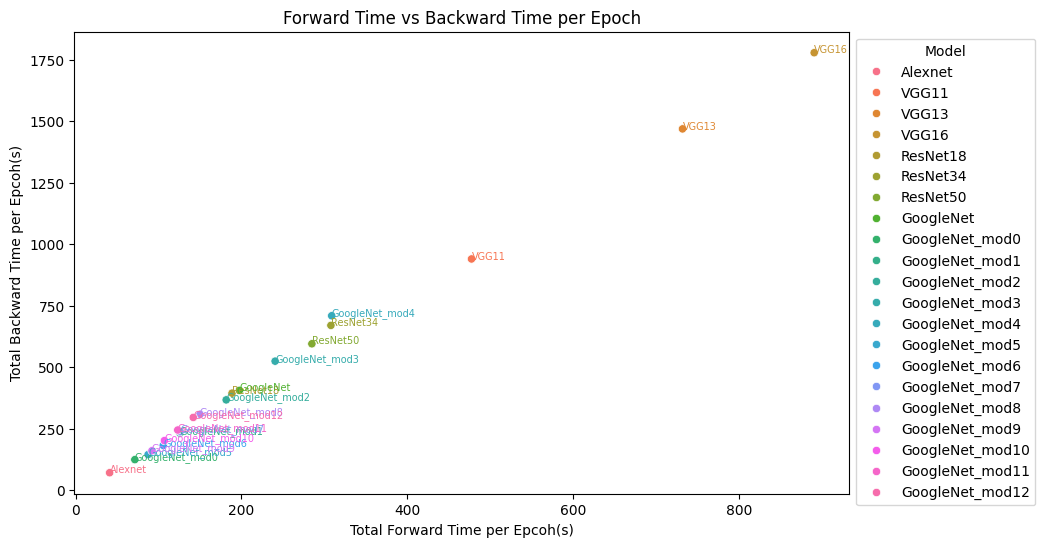

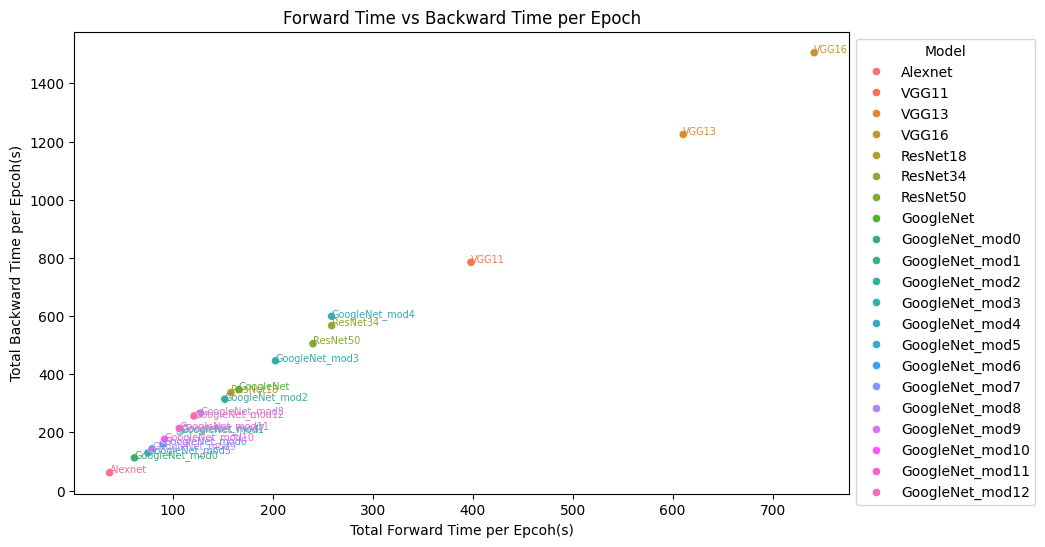

In [15]:
PlotForwardTime_vs_BackwardTime(df_f)
PlotForwardTime_vs_BackwardTime(df_c)

In [16]:
# save the dataframe to csv, and save to the data_model_dir
df_f.to_csv(os.path.join(data_model_dir, 'fashionmnist_datasetinfo.csv'), index=False)
df_c.to_csv(os.path.join(data_model_dir, 'cifar100_datasetinfo.csv'), index=False)